## Carga dos Dados e Pré-Processamento

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

import sklearn
from sklearn import metrics, model_selection, ensemble

In [2]:
df = pd.read_csv("bank/bank-full.csv", delimiter=";")
for v in ["default", "housing", "loan", "y"]:  # converting boolean (y/n) data to Bool
    df[v] = df[v] == "yes"
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,False,2143,True,False,unknown,5,may,261,1,-1,0,unknown,False
1,44,technician,single,secondary,False,29,True,False,unknown,5,may,151,1,-1,0,unknown,False
2,33,entrepreneur,married,secondary,False,2,True,True,unknown,5,may,76,1,-1,0,unknown,False
3,47,blue-collar,married,unknown,False,1506,True,False,unknown,5,may,92,1,-1,0,unknown,False
4,33,unknown,single,unknown,False,1,False,False,unknown,5,may,198,1,-1,0,unknown,False


### 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [3]:
(pd
 .concat([(df.housing | df.loan).rename("any loan"), df[["job", "housing", "loan"]]], axis=1)
 .groupby("job")
 .mean()
 .sort_values("any loan", ascending=False)
 .style.highlight_max(color='lightgreen').format("{:.2%}"))

,any loan,housing,loan
job,,,
blue-collar,78.08%,72.42%,17.30%
services,73.74%,66.59%,20.13%
admin.,69.02%,61.54%,19.16%
entrepreneur,68.33%,58.44%,23.94%
technician,60.66%,54.17%,17.23%
management,55.24%,49.46%,13.25%
self-employed,54.72%,48.45%,14.50%
unemployed,45.20%,41.67%,8.37%
housemaid,39.52%,32.10%,12.26%


Segundo os dados, operários (*blue-collar*), seguidos dos trabalhadores da indústria de serviços.
O tipo mais comum de empréstimo é o imobiliário, tanto para essa classe quanto as demais.

### 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

In [4]:
call_results = pd.crosstab(df.campaign, df.y)
call_success = df.groupby("campaign").y.mean()

print(f"Taxa de sucesso da campanha atual: {df.y.mean():.3}")

Taxa de sucesso da campanha atual: 0.117


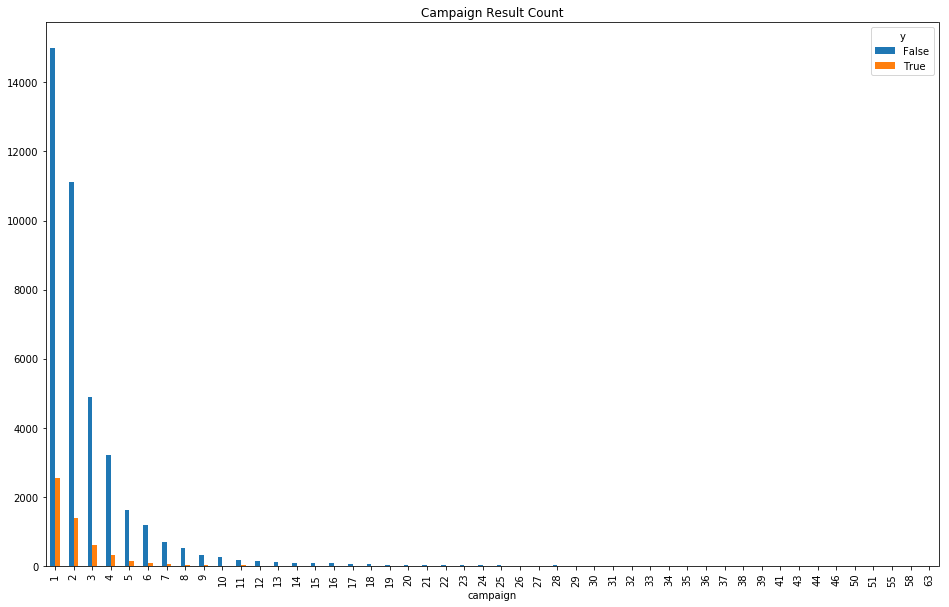

In [5]:
call_results.plot.bar(figsize=(16, 10), title="Campaign Result Count")

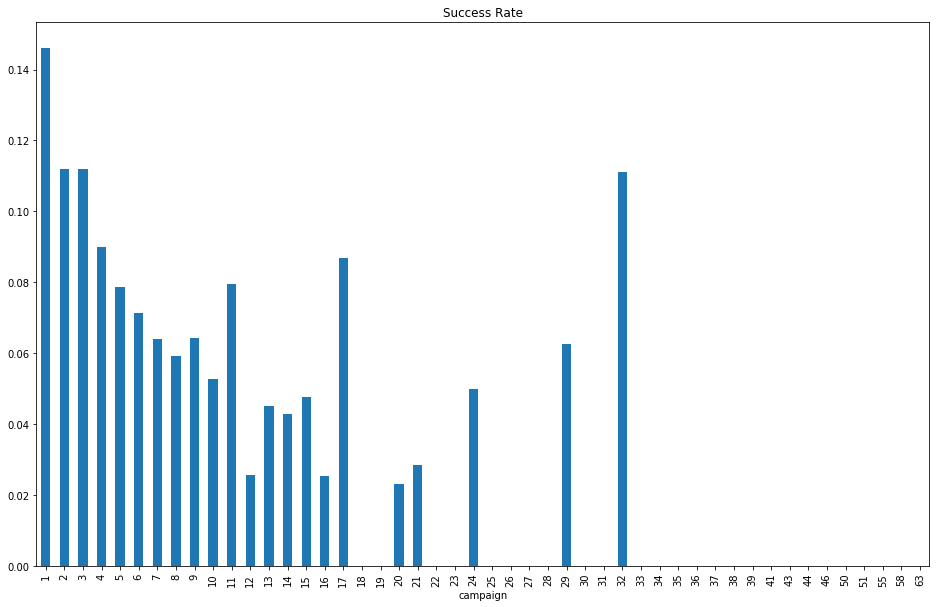

In [6]:
call_success.plot.bar(title="Success Rate", figsize=(16, 10))

O número de novas adesões cai rapidamente com o aumento do número de chamadas. A taxa de sucesso da terceira ligação em diante é menor do que a média global de sucesso. Um grande número de contatos representa em geral aumento de custos com retornos decrescentes, indicando a possível necessidade de se otimizar o tipo e alvo das chamadas.

### 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

In [7]:
successful = df[df.y]

In [8]:
successful.campaign.describe()

count    5289.000000
mean        2.141047
std         1.921826
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: campaign, dtype: float64

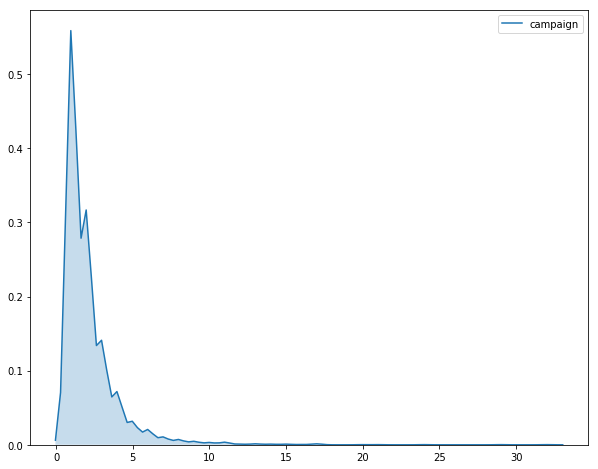

In [9]:
plt.figure(figsize=(10, 8))
sns.kdeplot(successful.campaign, shade=True)

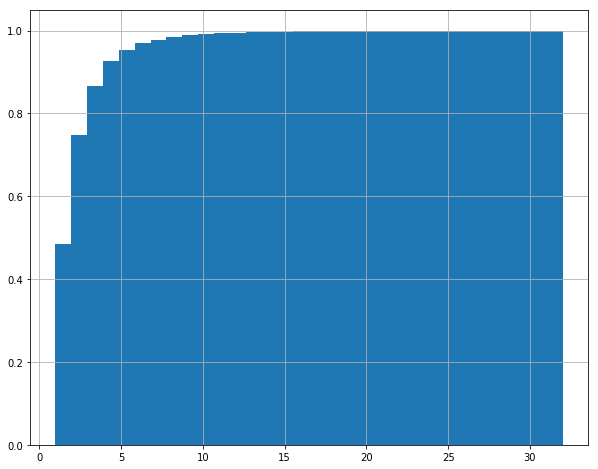

In [10]:
plt.figure(figsize=(10, 8))
successful.campaign.hist(cumulative=True, bins=successful.campaign.max(), density=True, histtype='stepfilled')

In [11]:
(successful.groupby("campaign").y.count().cumsum()/successful.campaign.count()).to_frame().style.format("{:.2%}")

,y
campaign,
1,48.42%
2,74.91%
3,86.59%
4,92.59%
5,95.22%
6,96.96%
7,97.84%
8,98.45%
9,98.85%


Cerca de 3/4 do sucesso da campanha atual se deu em até dois contatos, servindo como um valor médio. A adesão pode ser ainda aumentada com um máximo de 5 contatos, abarcando 95% dos resultados positivos. Além disto, o aumento do número não aparenta resultar em ganhos significativos de adesão.

### 4. O resultado da campanha anterior tem relevância na campanha atual?

In [12]:
df["py"] = df.poutcome == "success"
previous_results = df[(df.poutcome == "failure") | (df.poutcome == "success")]

In [13]:
print(
f"""Número de resultados anteriores com valor de sucesso ou falha: {previous_results.shape[0]}
Taxa de sucesso na campanha anterior para clientes com resultado claro: {(previous_results.poutcome == "success").mean():.2}
Taxa de sucesso na campanha atual para clientes com resultado claro na campanha anterior: {(previous_results.y).mean():.2}
Correlação de Pearson entre o resultado anterior e o atual para estes casos: {(previous_results.poutcome == "success").corr(previous_results.y):.2}""")

Número de resultados anteriores com valor de sucesso ou falha: 6412
Taxa de sucesso na campanha anterior para clientes com resultado claro: 0.24
Taxa de sucesso na campanha atual para clientes com resultado claro na campanha anterior: 0.25
Correlação de Pearson entre o resultado anterior e o atual para estes casos: 0.51


In [14]:
confusion = pd.crosstab(
    previous_results.poutcome == "success",
    previous_results.y,
    rownames=["current result"],
    colnames=["previous result"],
    normalize="index").style.format("{:.2%}")
display(confusion)

previous result,False,True
current result,,
False,87.39%,12.61%
True,35.27%,64.73%


In [15]:
print(metrics.classification_report(previous_results.y, previous_results.poutcome == "success"))

              precision    recall  f1-score   support

       False       0.87      0.89      0.88      4816
        True       0.65      0.61      0.63      1596

    accuracy                           0.82      6412
   macro avg       0.76      0.75      0.76      6412
weighted avg       0.82      0.82      0.82      6412



Selecionando para análise apenas dados com resultado anterior claro ("success" ou "failure"),
o r de Pearson entre as duas campanhas aparenta indicar correlação média. A matriz de confusão
e o relatório de classificação também sugerem uma relação, apesar do forte desequilíbro de
classes entre sucesso e falha, com precisão (taxa de positivos verdadeiros sobre taxa de positivos)
de 65% dado o resultado anterior como preditor. Estes resultados parecem indicar relevância.

### 5. Qual o fator determinante para que o banco exija um seguro de crédito?

Considerando para a questão que os dados disponíveis são os pessoais ao cliente, e que a variável objetivo que faria um banco exigir seguro ou não "default" (não pagamento de dívida).

In [16]:
cm_green = sns.light_palette("green", as_cmap=True)

In [17]:
print(f"Taxa de default para os dados: {df.default.mean():.2%}")

Taxa de default para os dados: 1.80%


In [18]:
df.groupby("default")[["age", "balance"]].describe()

age                                                      balance  \
           count       mean        std   min   25%   50%   75%   max    count   
default                                                                         
False    44396.0  40.961934  10.638882  18.0  33.0  39.0  48.0  95.0  44396.0   
True       815.0  39.534969   9.357804  21.0  32.0  38.0  47.0  71.0    815.0   

                                                                            
                mean          std     min    25%    50%      75%       max  
default                                                                     
False    1389.806424  3063.275425 -4057.0   84.0  468.0  1462.25  102127.0  
True     -137.624540   906.704678 -8019.0 -339.0   -7.0    15.00   16486.0

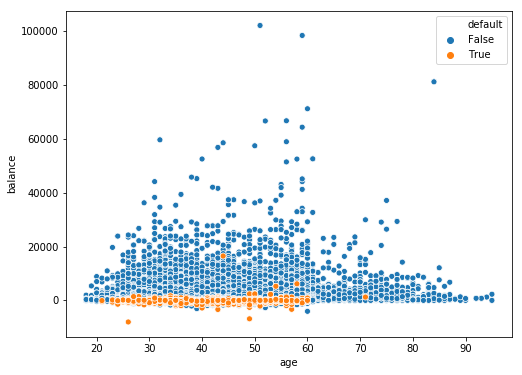

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot("age", "balance", hue="default", data=df.sort_values("default"), sizes=[1, 10])

In [20]:
df.groupby("job").default.mean().to_frame().sort_values("default", ascending=False).style.format("{:.2%}")

,default
job,
entrepreneur,3.70%
unemployed,2.30%
self-employed,2.09%
blue-collar,2.07%
services,1.81%
housemaid,1.77%
management,1.73%
technician,1.71%
admin.,1.43%


In [21]:
df.groupby("education").default.mean().to_frame().sort_values("default", ascending=False).style.format("{:.2%}")

,default
education,
secondary,1.97%
primary,1.85%
unknown,1.72%
tertiary,1.49%


In [22]:
df.groupby("marital").default.mean().to_frame().sort_values("default", ascending=False).style.format("{:.2%}")

,default
marital,
divorced,2.46%
single,1.87%
married,1.65%


In [23]:
pd.pivot_table(
    df,
    index=["job"],
    columns=["education", "marital"],
    values=["default"],
    ).style.background_gradient(cmap=cm_green).format("{:.2%}")

Considerando as duas feições numéricas separadamente, saldo médio parece indicar uma diferença maior entre as distribuições agrupadas por default.
Apesar do gráfico de dispersão parecer mostrar um intervalo de idades para a categoria default, é possível que se trate de um artefato amostral,
considerando as distribuições com parâmetros próximos.

Dentre as categóricas, profissão parece indicar alguma relevância, visto que empreendedores tem cerca do dobro da taxa de default da população.
A tabela pivô detalha as relações cruzadas e sugere algumas categorias anômalas, destacadas. Mais uma vez, a pequena quantidade de dados com valor
de default verdadeiro aumenta a chance destas serem apenas artefatos.

Para um tratamento envolvendo todas estas variáveis em conjunto, um possível tratamento é treinar um classificador que possua como saída valores
de importância de feições, como uma floresta aleatória. No caso desta (e de sua implementação na biblioteca scikit-learn) a importância de feições
é calculada a partir da redução do coeficiente de Gini em cada nó de cada árvore, agregada por feição.

In [24]:
df_personal_ind = pd.concat([  # seleção de variáveis pessoais e conversão de categóricas para numéricas via codificação indicadora (one-hot)
    df[["age", "balance", "housing", "loan"]],
    pd.get_dummies(df.job, prefix="job"),
    pd.get_dummies(df.education, prefix="education"),
    pd.get_dummies(df.marital, prefix="marital")], axis=1)
default = df["default"]

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
     df_personal_ind, default, test_size=0.25, random_state=0)

In [26]:
clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)

In [27]:
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Text(0,0.5,'True positive rate')

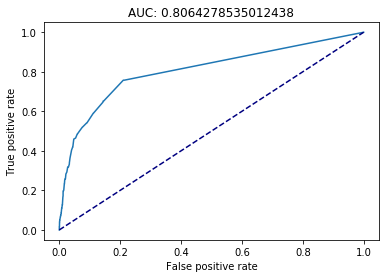

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba[:,1], pos_label=1)

auc = metrics.roc_auc_score(y_test, y_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

In [29]:
print(metrics.classification_report(y_test, y_pred))#, y_proba[:,1] > 0.9))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     11105
        True       0.32      0.06      0.09       198

    accuracy                           0.98     11303
   macro avg       0.65      0.53      0.54     11303
weighted avg       0.97      0.98      0.97     11303



In [30]:
pd.crosstab(
    y_pred,
    y_test,
    rownames=["default"],
    colnames=["predicted"],
    normalize="index").style.format("{:.2%}")

predicted,False,True
default,,
False,98.34%,1.66%
True,67.65%,32.35%


Apesar dos scores em geral baixos para a classificação de verdadeiros positivos, há indicativo de alguma capacidade preditiva com a precisão de 0.32. Utilizando isto e treinando a floresta para todos os dados,

In [31]:
gini_importances = pd.DataFrame(
    {"importance": ensemble.RandomForestClassifier(n_estimators=100, random_state=0).fit(df_personal_ind, default).feature_importances_},
    index=df_personal_ind.columns)

In [32]:
gini_importances.sort_values("importance", ascending=False)[:10].style.format("{:.2%}")

,importance
balance,54.77%
age,27.22%
housing,2.46%
loan,2.15%
education_secondary,1.16%
marital_single,1.02%
job_blue-collar,1.01%
job_technician,0.96%
marital_married,0.96%
job_management,0.93%


In [33]:
gini_importances.groupby(
    lambda f: f.split("_")[0]).sum().sort_values("importance", ascending=False).style.format("{:.2%}")

,importance
balance,54.77%
age,27.22%
job,7.25%
education,3.47%
marital,2.68%
housing,2.46%
loan,2.15%


A primeira tabela trata cada categoria das feições categóricas como uma variável separada, mostrando as 10 com maior importância. Na segunda, as categorias foram reagrupadas em suas feições originais.

Nesta situação, saldo e idade se apresentam como importantes para a classificação em ambas com importância muito acima das seguintes, profissão e educação na agrupada e empréstimos imobiliário e pessoal na desagrupada. De qualquer forma, é necessário cuidado em qualquer interpretação deste tipo, não sendo provavelmente informações suficientes para a decisão de exigência de seguro ou não, salvo informadas pelas políticas do banco quanto ao risco aceitável. Outras feições provavelmente seriam necessárias para um modelo (como maiores detalhes sobre a situação de crédito em dívida, e se já houveram situações anteriores), assim como maior base de dados para aumentar a representatividade.

### 6. Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

In [34]:
df_personal = df[["age", "balance", "housing", "loan", "job", "education", "marital"]]

In [35]:
df.groupby("housing")[["age", "balance"]].describe()

age                                                      balance  \
           count       mean        std   min   25%   50%   75%   max    count   
housing                                                                         
False    20081.0  43.139883  12.058696  18.0  33.0  42.0  52.0  95.0  20081.0   
True     25130.0  39.175288   8.926807  20.0  32.0  38.0  45.0  78.0  25130.0   

                                                                           
                mean          std     min   25%    50%      75%       max  
housing                                                                    
False    1596.501270  3613.405339 -8019.0  85.0  507.0  1708.00  102127.0  
True     1175.103064  2483.285761 -4057.0  62.0  412.0  1257.75   58544.0

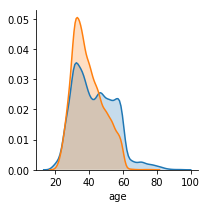

In [36]:
sns.FacetGrid(df, hue="housing").map(sns.kdeplot, "age", shade=True)

In [37]:
df.groupby("housing")[["age", "balance"]].std()

,age,balance
housing,,
False,12.058696,3613.405339
True,8.926807,2483.285761


In [38]:
pd.crosstab(df_personal.job, df_personal.housing, normalize="columns").style.format("{:.2%}")

housing,False,True
job,,
admin.,9.90%,12.66%
blue-collar,13.37%,28.05%
entrepreneur,3.08%,3.46%
housemaid,4.19%,1.58%
management,23.80%,18.62%
retired,8.83%,1.95%
self-employed,4.05%,3.04%
services,6.91%,11.01%
student,3.43%,0.99%


In [39]:
pd.crosstab(df_personal.education, df_personal.housing, normalize="columns").style.format("{:.2%}")

housing,False,True
education,,
primary,14.73%,15.50%
secondary,45.64%,55.86%
tertiary,34.48%,25.38%
unknown,5.16%,3.26%


In [40]:
pd.crosstab(df_personal.marital, df_personal.housing, normalize="columns").style.format("{:.2%}")

housing,False,True
marital,,
divorced,11.45%,11.57%
married,59.23%,60.97%
single,29.32%,27.47%


Os dados fornecidos sugerem como características de diferenciação dos clientes com empréstimo imobiliário:
* mais jovens (idade média de 39 anos versus 43, além de distribuição mais próxima da média com menor desvio padrão e IQR)
* saldo bancário médio mais baixo (ambos com distribuição fortemente assimétrica positiva, mas com quartis sistematicamente mais baixos)
* grau de escolaridade mais concentrado em secundário
* setor de profissão mais comum operário, versus gerencial